In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8518518518518519, Loss: 0.6936406736020688
Checkpoint 200, Accuracy: 0.8148148148148148, Loss: 0.7102473930076316
Checkpoint 300, Accuracy: 0.8148148148148148, Loss: 0.7102473930076316
Checkpoint 400, Accuracy: 0.808641975308642, Loss: 0.716297432228371
Checkpoint 500, Accuracy: 0.8148148148148148, Loss: 0.7115881884539569


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8603812 ]
 [0.08037746]
 [0.05924143]]
[1. 0. 0.] <-> [[0.8122569 ]
 [0.1070981 ]
 [0.08064502]]
[0. 1. 0.] <-> [[0.18615799]
 [0.4242622 ]
 [0.3895798 ]]
[1. 0. 0.] <-> [[0.5963541 ]
 [0.22295146]
 [0.18069442]]
[0. 1. 0.] <-> [[0.7518009 ]
 [0.1401671 ]
 [0.10803201]]
[0. 0. 1.] <-> [[0.23399301]
 [0.40204963]
 [0.36395743]]
[0. 0. 1.] <-> [[0.6893173 ]
 [0.1738205 ]
 [0.13686225]]
[1. 0. 0.] <-> [[0.8982134 ]
 [0.05907962]
 [0.04270698]]
[1. 0. 0.] <-> [[0.35359147]
 [0.3455099 ]
 [0.3008986 ]]
[1. 0. 0.] <-> [[0.93108267]
 [0.04030787]
 [0.02860939]]
[1. 0. 0.] <-> [[0.4484934 ]
 [0.29869214]
 [0.25281438]]
[1. 0. 0.] <-> [[0.39983517]
 [0.32289326]
 [0.2772716 ]]
[0. 0. 1.] <-> [[0.54308426]
 [0.2505936 ]
 [0.20632216]]
[1. 0. 0.] <-> [[0.9317755 ]
 [0.03990871]
 [0.02831578]]
[1. 0. 0.] <-> [[0.38613355]
 [0.32963502]
 [0.28423145]]
[0. 1. 0.] <-> [[0.20171757]
 [0.4169341 ]
 [0.38134834]]
[1. 0. 0.] <-> [[0.920042  ]
 [0.04664721]
 [0.03331087]]
[0. 1. 0.] <->

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


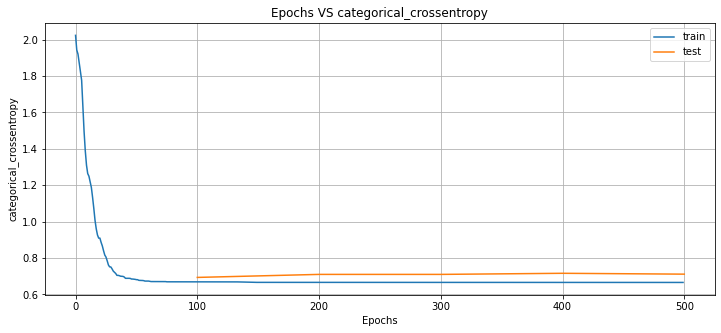

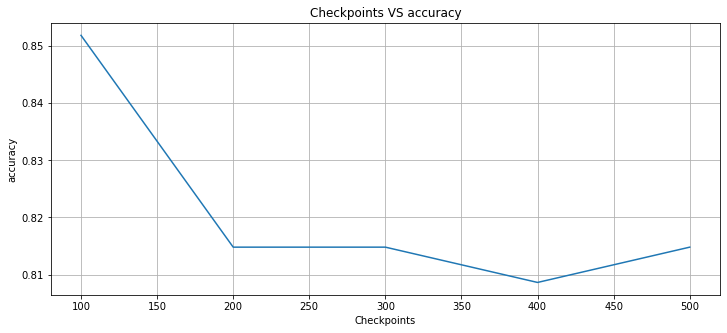

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8518518518518519, 'mean_square_error': 2.8161590738202733, 'categorical_crossentropy': 0.6936406736020688, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 18, 'tn_hit': 14, 'fn_hit': 1}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 17}, 2: {'tp_hit': 9, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 2.793262113714599, 'categorical_crossentropy': 0.7102473930076316, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 5}, 1: {'tp_hit': 7, 'fp_hit': 15, 'tn_hit': 76, 'fn_hit': 10}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 200} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 2.793262113714599, 'categorical_crossentropy': 0.7102473930076316, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 5}, 1: {'tp_hit': 7, 'fp_hit': 15, 'tn_hit': 76, 'fn_hit': 10}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[-0.2662771 ]
 [-0.25224498]
 [-0.37788558]
 [-0.27683926]
 [-0.29189932]]
 bias: [0.34026533]

Neuron 1: weights:
[[0.272131  ]
 [0.33755887]
 [0.25550535]
 [0.33141908]
 [0.14085522]]
 bias: [0.03009451]

Neuron 2: weights:
[[-0.19013949]
 [-0.41484907]
 [-0.21325323]
 [-0.3652554 ]
 [-0.29569125]]
 bias: [0.18763143]

Neuron 3: weights:
[[-0.13398063]
 [-0.27871665]
 [-0.24218945]
 [-0.21525797]
 [-0.3620044 ]]
 bias: [0.0707476]

$
Layer 2
Neuron 0: weights:
[[ 0.58892673]
 [-0.7200458 ]
 [ 0.83150023]
 [ 0.76530075]]
 bias: [0.11933978]

Neuron 1: weights:
[[-0.2473831 ]
 [ 0.2540837 ]
 [-0.3670782 ]
 [-0.45881447]]
 bias: [-0.00904789]

Neuron 2: weights:
[[-0.49787104]
 [ 0.2910071 ]
 [-0.5259979 ]
 [-0.2754514 ]]
 bias: [-0.13096191]

$

